In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install gtts
!pip install playsound

     |████████████████████████████████| 62 kB 949 kB/s             
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
spacy 3.2.2 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
gcsfs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.2.0 which is incompatible.
apache-beam 2.34.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.34.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.2 which is incompa

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.activations import softmax, tanh, relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu

from collections import Counter
import string
import time
from PIL import Image
from tqdm import tqdm
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
from wordcloud import WordCloud

# Creating dataframe

In [4]:
images = '/kaggle/input/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
txt_file = '/kaggle/input/flickr8k/captions.txt'

def load_doc(filename):
    open_file = open(txt_file, 'r', encoding='latin-1')
    txt = open_file.read() 
    open_file.close()
    
    return txt

doc = load_doc(txt_file)
print(doc[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [6]:
imgs = '/kaggle/input/flickr8k/Images/'

img_id = [] # All image ID
img_path = [] # All image paths
captions = [] # All captions

with open('/kaggle/input/flickr8k/captions.txt' , 'r') as fo:
    next(fo) 
    for line in fo :
        split_arr = line.split(',')
        img_id.append(split_arr[0])
        captions.append(split_arr[1].rstrip('\n.')) 
        img_path.append(imgs + split_arr[0])

df = pd.DataFrame(list(zip(img_id, img_path, captions)),columns =['Image ID','Image Path','Captions']) 
    
df

Image ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                              Image Path  \
0      /kaggle/input/flickr8k/Images/1000268201_693b0...   
1      /kaggle/input/flickr8k/Images/1000268201_693b0...   
2      /kaggle/input/flickr8k/Images/1000268201_693b0...   
3      /kaggle/input/flickr8k/Images/1000268201_693b0...   
4      /kaggle/input/flickr8k/Images/1000268201_693b0...   
...                                                  ...   
40450  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40451  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40452  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40453  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40454  /kaggle/input/flickr8k/Images/997722733_0cb543...   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

# Visualizing Data

In [7]:
vocab = [word.lower() for line in captions for word in line.split()]

### Bar Graph

a : 60196
in : 18174
the : 17507
on : 10357
is : 9069
and : 8057
dog : 7948
with : 7304
man : 7137
of : 6495


Text(0, 0.5, 'Frequency')

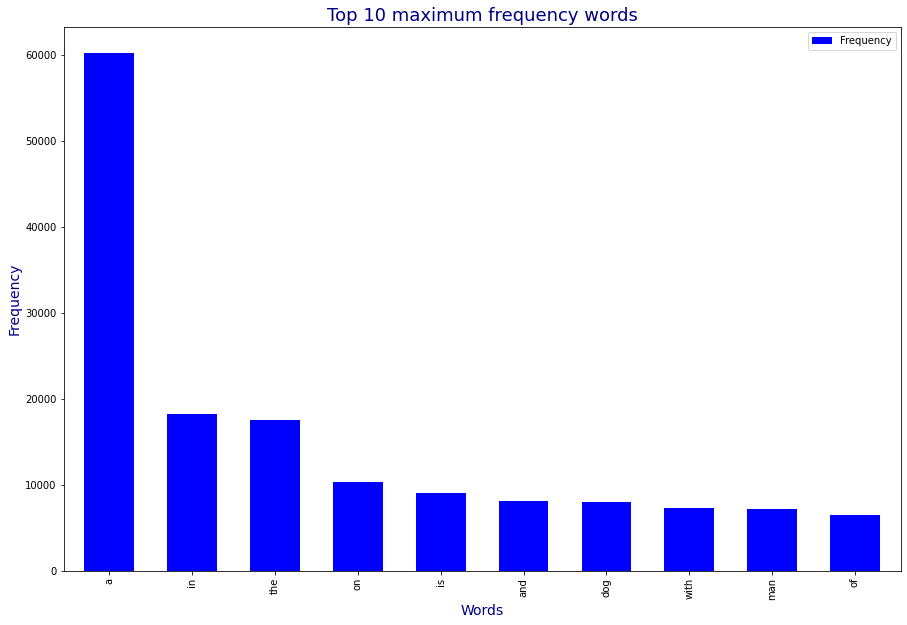

In [8]:
counter = Counter(vocab) 

for word, count in counter.most_common(10):
    print(word, ":", count)

lst = counter.most_common(10)
freq_df = pd.DataFrame(lst, columns = ['Word', 'Frequency'])
freq_df.plot.bar(x='Word', y='Frequency', width=0.6, color='blue', figsize=(15, 10))
plt.title("Top 10 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Frequency", fontsize = 14, color= 'navy')

### WordCloud

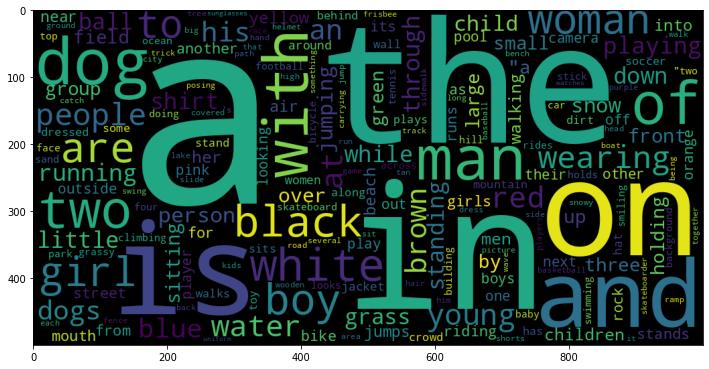

In [9]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(counter)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

### Image + Caption

In [10]:
def plot_img_cap(img_id, df) :
    capt = ("\n" *2).join(df[df['Image ID'] == img_id]['Captions'].to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx = df['Image ID'].to_list().index(img_id)
    im = Image.open(df['Image Path'].iloc[idx])
    w, h = im.size[0], im.size[-1]
    ax.imshow(im)
    ax.text(w+50, h, capt, fontsize = 18, color = 'navy')

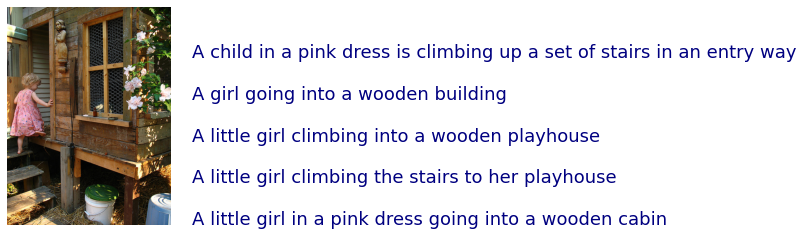

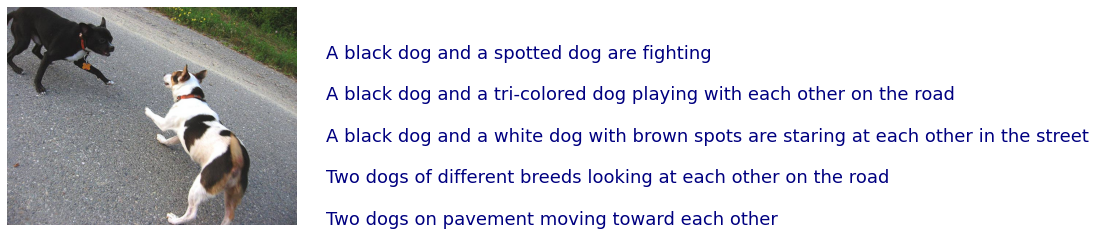

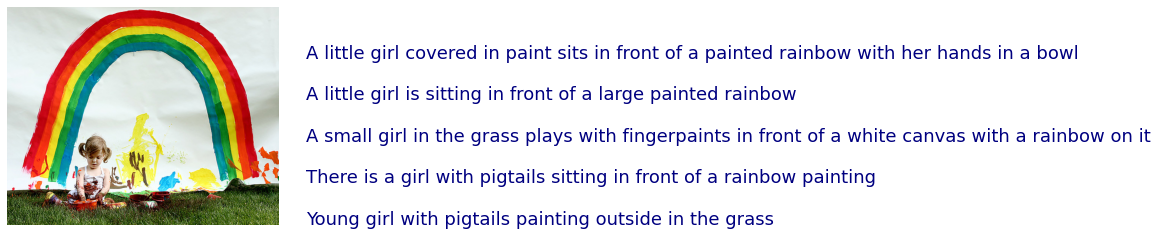

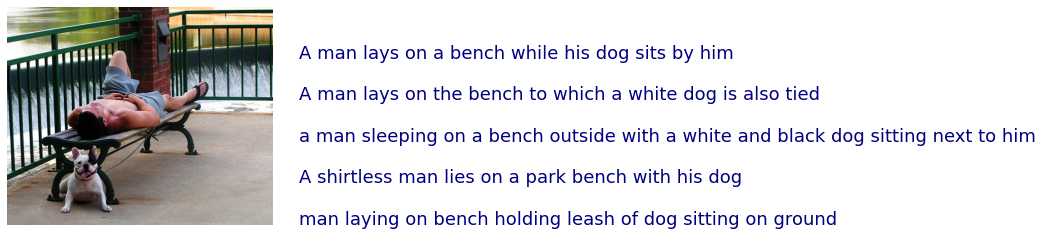

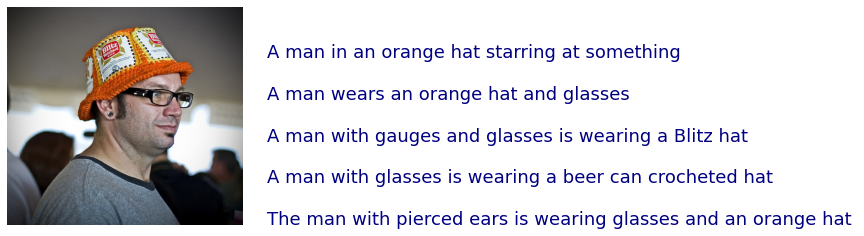

In [11]:
for r in range(0,5) :
    plot_img_cap(df['Image ID'].drop_duplicates().iloc[r], df)

# Cleaning and Preprocessing Data

In [12]:
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(captions)) :
    line = captions[r]
    line = line.split()

    line = [word.lower() for word in line]
    line = [word.translate(rem_punct) for word in line]
    line = [word for word in line if len(word) > 1]
    line = [word for word in line if word.isalpha()]

    captions[r] = ' '.join(line)

In [13]:
captions = ['<start>' + ' ' + line + ' ' + '<end>' for line in captions]

In [14]:
captions[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [15]:
counter_2 = 5000
tokenizer = Tokenizer(num_words = counter_2+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

In [16]:
tokenizer.fit_on_texts(captions)

In [17]:
seqs = tokenizer.texts_to_sequences(captions)

In [18]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'   # Adding padding to words

In [19]:
seqs_len = [len(seq) for seq in seqs]
longest = max(seqs_len)
cap_vector= pad_sequences(seqs, padding= 'post', maxlen = longest,
                                                          dtype='int32', value=0)

cap_vector.shape

(40455, 31)

In [20]:
preprocessed = []
IMAGE_SHAPE = (299, 299)

In [21]:
for img in all_imgs[0:5] :
    img = read_file(img, name=None)
    
    img = decode_jpeg(img, channels=0)
    img = resize(img, (299, 299))
    img = preprocess_input(img)
    
    preprocessed.append(img)

Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


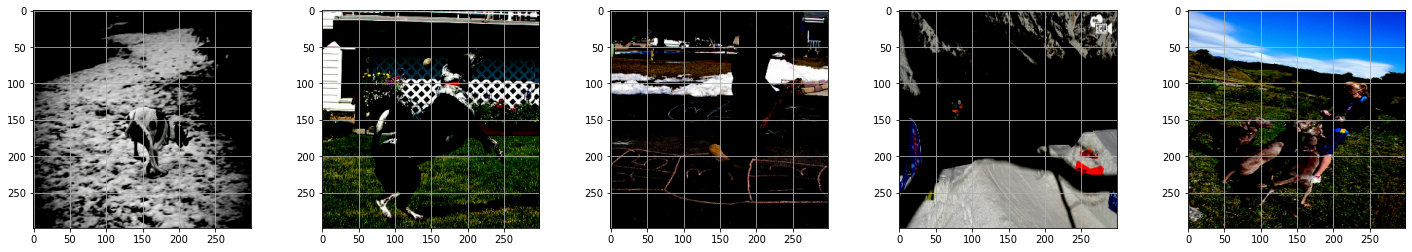

In [22]:
fig, axes = plt.subplots(1,5)
fig.set_figwidth(25)

for ax, image in zip(axes, preprocessed[0:5]) :
    print('Shape after resize : ', image.shape)
    ax.imshow(image)
    ax.grid('off')

In [23]:
def load_images(image_path) :
    img = read_file(image_path, name = None)
    img = decode_jpeg(img, channels=0)
    img = resize(img, IMAGE_SHAPE)
    img = preprocess_input(img)
    return img, image_path

In [24]:
new_paths = sorted(set(img_path))
new_images = Dataset.from_tensor_slices(new_paths)
new_images = new_images.map(load_images, num_parallel_calls = AUTOTUNE)
new_images = new_images.batch(64, drop_remainder=False)

In [25]:
new_images

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

In [26]:
img_train, img_test, cap_train, cap_test = train_test_split(img_path, cap_vector, test_size = 0.2, random_state = 42)

In [27]:
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


# Feature extraction

In [28]:
img_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_inp = img_model.input 
hidden = img_model.layers[-1].output 
extractor = tf.compat.v1.keras.Model(new_inp, hidden)

87924736/87910968 [==============================] - 2s 0us/step


In [29]:
extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [30]:
img_features = {}
for img, img_path in tqdm(new_images):
    
    batch_features = extractor(img)
    batch_features_flat = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for batch_feat, path in zip(batch_features_flat, img_path):
        feat_path = path.numpy().decode('utf-8')
        img_features[feat_path] = batch_feat.numpy()

100%|██████████| 127/127 [00:34<00:00,  3.64it/s]


In [31]:
len(img_features)

8091

In [32]:
batch_feat.shape

TensorShape([64, 2048])

In [33]:
def map(img_name, cap):
    img_tensor = img_features[img_name.decode('utf-8')]
    return img_tensor, cap

In [34]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_ds(img, cap):
    
    data = Dataset.from_tensor_slices((img, cap))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = AUTOTUNE)
    
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(AUTOTUNE))

    return data

In [35]:
train_ds = gen_ds(img_train, cap_train)
test_ds = gen_ds(img_test,cap_test)

In [36]:
sample_img_batch, sample_cap_batch = next(iter(train_ds))
print(sample_img_batch.shape)  
print(sample_cap_batch.shape) 

(64, 64, 2048)
(64, 31)


# Model

In [37]:
embedding_dim = 256 
units = 512

vocab_size = 5001
train_steps = len(img_train) // BATCH_SIZE 
test_steps = len(img_test) // BATCH_SIZE  

max_length = 31
feat_shape = batch_feat.shape[1]
attn_feat_shape = batch_feat.shape[0]

### Encoder

In [38]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim) 
        
    def call(self, features):
        features =  self.dense(features) 
        features =  relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [39]:
encoder=Encoder(embedding_dim)

### Attention Model

In [40]:
class Attn_model(Model):
    def __init__(self, units):
        super(Attn_model, self).__init__()
        self.W1 = Dense(units) 
        self.W2 = Dense(units)
        self.V = Dense(1) 
        self.units=units

    def call(self, features, hidden):
        
        hidden_time = hidden[:, tf.newaxis]
        score = tanh(self.W1(features) + self.W2(hidden_time))  
        attn_weights = softmax(self.V(score), axis=1) 
        context_vector = attn_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attn_weights

### Decoder

In [41]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attn_model(self.units) 
        self.embed = Embedding(vocab_size, embed_dim) 
        self.gru = GRU(self.units,return_sequences=True, return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units) 
        self.d2 = Dense(vocab_size) 
        

    def call(self,x,features, hidden):
        context_vector, attn_weights = self.attention(features, hidden) 
        embed = self.embed(x) 
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)  
        output,state = self.gru(embed) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output)
        
        return output, state, attn_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [42]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [43]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_in = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

pred, hidden_out, attn_weights= decoder(dec_in, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(pred.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attn_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


# Model training

In [44]:
optimizer = Adam(learning_rate = 0.001)  
loss_object = SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) 

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [46]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [47]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [48]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:

        encoder_op = encoder(img_tensor)

        for r in range(1, target.shape[1]) :
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions) 
            dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/int(target.shape[1])) 
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient(loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [49]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)

        for r in range(1, target.shape[1]) :
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions)

            dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    
    optimizer.apply_gradients(zip(grad, trainable_vars))                      

    return loss, avg_loss

In [50]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss = total_loss + t_loss
        avg_test_loss = total_loss/ test_steps

    return avg_test_loss

In [51]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_ds)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:43<38:12, 163.73s/it]

For epoch: 1, the train loss is 1.447, & test loss is 1.209
Time taken for 1 epoch 163.52785754203796 sec

Test loss has been reduced from 100.000 to 1.209


 13%|█▎        | 2/15 [03:51<23:18, 107.56s/it]

For epoch: 2, the train loss is 1.116, & test loss is 1.062
Time taken for 1 epoch 68.08795666694641 sec

Test loss has been reduced from 1.209 to 1.062


 20%|██        | 3/15 [05:00<17:54, 89.57s/it] 

For epoch: 3, the train loss is 1.008, & test loss is 0.976
Time taken for 1 epoch 67.97801971435547 sec

Test loss has been reduced from 1.062 to 0.976


 27%|██▋       | 4/15 [06:08<14:51, 81.03s/it]

For epoch: 4, the train loss is 0.934, & test loss is 0.906
Time taken for 1 epoch 67.79753732681274 sec

Test loss has been reduced from 0.976 to 0.906


 33%|███▎      | 5/15 [07:16<12:43, 76.32s/it]

For epoch: 5, the train loss is 0.872, & test loss is 0.849
Time taken for 1 epoch 67.77592134475708 sec

Test loss has been reduced from 0.906 to 0.849


 40%|████      | 6/15 [08:23<11:01, 73.46s/it]

For epoch: 6, the train loss is 0.820, & test loss is 0.797
Time taken for 1 epoch 67.75189185142517 sec

Test loss has been reduced from 0.849 to 0.797


 47%|████▋     | 7/15 [09:31<09:32, 71.62s/it]

For epoch: 7, the train loss is 0.771, & test loss is 0.751
Time taken for 1 epoch 67.65757894515991 sec

Test loss has been reduced from 0.797 to 0.751


 53%|█████▎    | 8/15 [10:39<08:12, 70.32s/it]

For epoch: 8, the train loss is 0.728, & test loss is 0.707
Time taken for 1 epoch 67.35472965240479 sec

Test loss has been reduced from 0.751 to 0.707


 60%|██████    | 9/15 [11:47<06:57, 69.55s/it]

For epoch: 9, the train loss is 0.688, & test loss is 0.669
Time taken for 1 epoch 67.6772530078888 sec

Test loss has been reduced from 0.707 to 0.669


 67%|██████▋   | 10/15 [12:54<05:45, 69.02s/it]

For epoch: 10, the train loss is 0.649, & test loss is 0.632
Time taken for 1 epoch 67.64488339424133 sec

Test loss has been reduced from 0.669 to 0.632


 73%|███████▎  | 11/15 [14:02<04:34, 68.67s/it]

For epoch: 11, the train loss is 0.614, & test loss is 0.598
Time taken for 1 epoch 67.70070791244507 sec

Test loss has been reduced from 0.632 to 0.598


 80%|████████  | 12/15 [15:10<03:25, 68.40s/it]

For epoch: 12, the train loss is 0.581, & test loss is 0.567
Time taken for 1 epoch 67.59714341163635 sec

Test loss has been reduced from 0.598 to 0.567


 87%|████████▋ | 13/15 [16:18<02:16, 68.20s/it]

For epoch: 13, the train loss is 0.551, & test loss is 0.538
Time taken for 1 epoch 67.58707928657532 sec

Test loss has been reduced from 0.567 to 0.538


 93%|█████████▎| 14/15 [17:25<01:07, 67.97s/it]

For epoch: 14, the train loss is 0.523, & test loss is 0.513
Time taken for 1 epoch 67.25857257843018 sec

Test loss has been reduced from 0.538 to 0.513


100%|██████████| 15/15 [18:33<00:00, 74.23s/it]

For epoch: 15, the train loss is 0.501, & test loss is 0.487
Time taken for 1 epoch 67.44382309913635 sec

Test loss has been reduced from 0.513 to 0.487


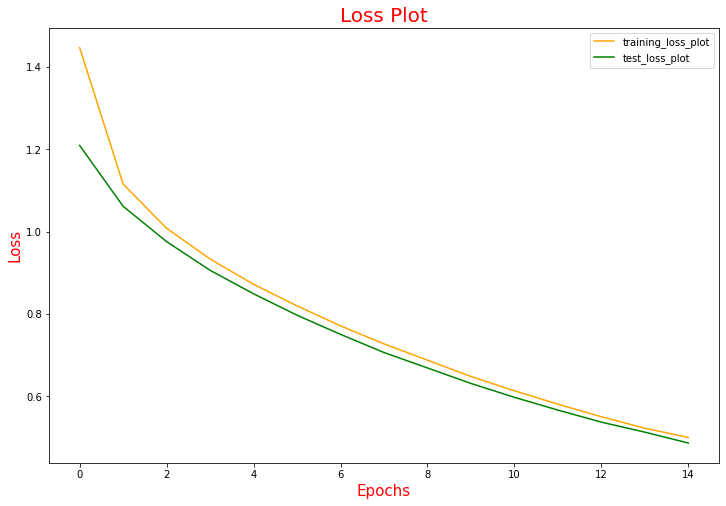

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

# Model Evaluation

In [53]:
def evaluate(image):
    attn_plot = np.zeros((max_length, attn_feat_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_inp = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = extractor(temp_inp) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        pred, hidden, attn_weights = decoder(dec_input, features, hidden) 

        attn_plot[i] = tf.reshape(attn_weights, (-1, )).numpy()

        pred_id = tf.argmax(pred[0]).numpy() 
        result.append (tokenizer.index_word[pred_id])

        if tokenizer.index_word[pred_id] == '<end>':
            return result, attn_plot, pred

        dec_input = tf.expand_dims([pred_id], 0)

    attn_plot = attn_plot[:len(result), :]
    return result, attention_plot, pred

In [54]:
def plot_attn_map (caption, weights, img) :

    fig = plt.figure(figsize = (10, 10))
    temp_img = np.array(Image.open(img))

    cap_len = len(caption)
    for cap in range(cap_len) :
        weights_img_1 = np.reshape(weights[cap], (8,8))
        weights_img_2 = np.array(Image.fromarray(weights_img_1).resize((224,224), Image.LANCZOS))

        ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
        ax.set_title(caption[cap], fontsize = 14, color = 'red')

        img = ax.imshow(temp_img)

        ax.imshow(weights_img_1, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [55]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [57]:
image_test = img_test.copy()

In [71]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = cap_test.copy()
    rid = np.random.randint(0, random)
    test_img = image_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_img)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attn_map(result, attention_plot, test_img)
    
    speech = gTTS(pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_img

### Img 1

BLEU score: 79.61568256608665
Real Caption: child turning crank with benches behind him
Prediction Caption: young boy turning crank with benches behind him


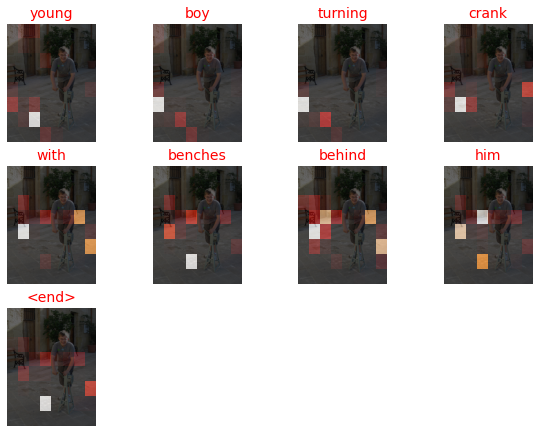

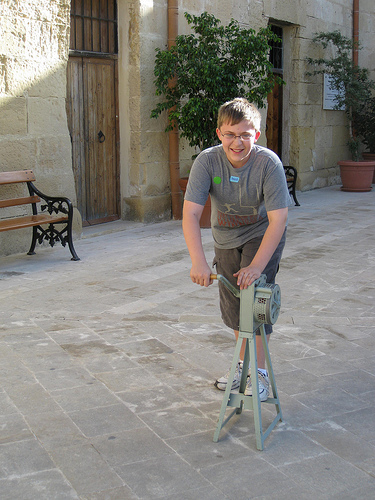

In [79]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

### Img 2

BLEU score: 85.99476570625983
Real Caption: woman wearing yellow shirt runs along red track
Prediction Caption: woman in yellow shirt runs along red track


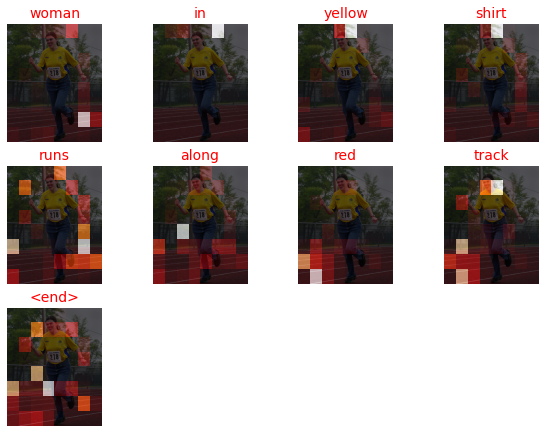

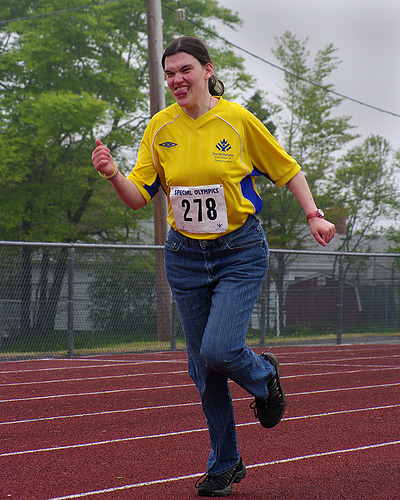

In [86]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

### Img 3

BLEU score: 100.0
Real Caption: woman and child walking uphill
Prediction Caption: woman and child walking uphill


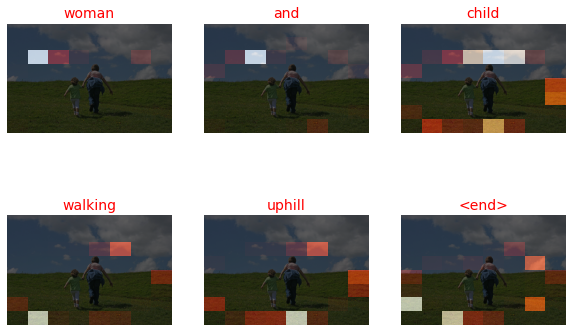

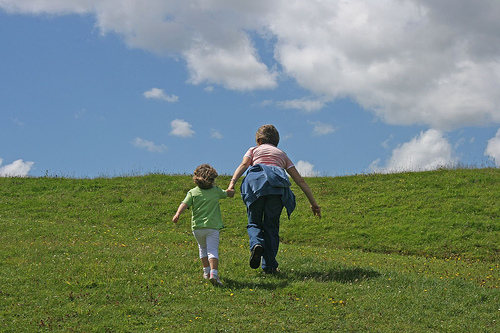

In [97]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)


### Img 4

BLEU score: 84.64817248906141
Real Caption: dog jumps to catch red ball outside
Prediction Caption: dog jumps to catch red ball


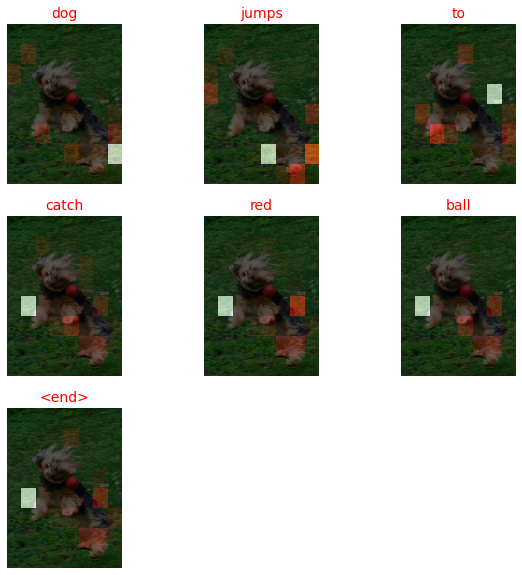

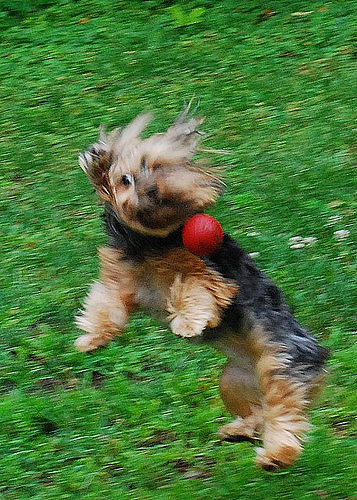

In [99]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.35, 0.25, 0, 0))
Image.open(test_image)

### Img 5

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 41.36895450425727
Real Caption: two dogs run towards shore through shallow water
Prediction Caption: two dogs run through the water


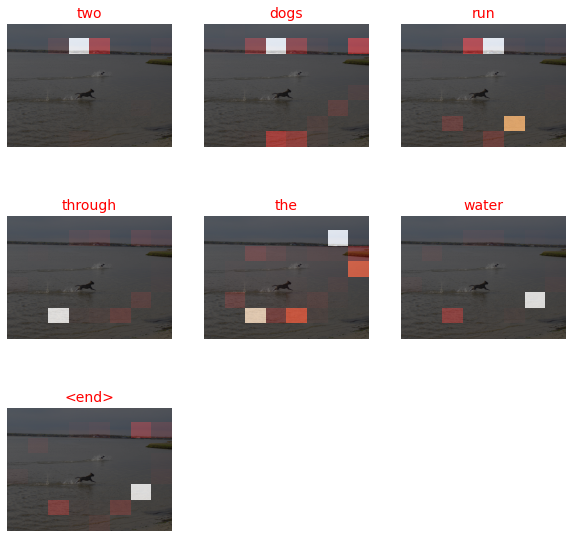

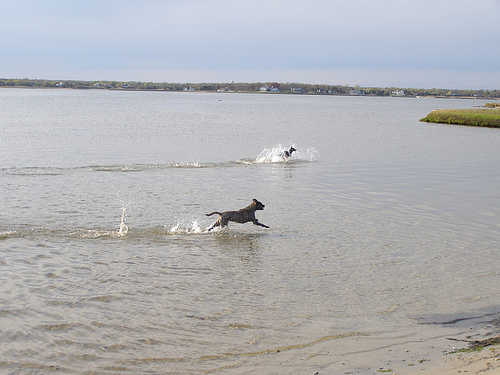

In [101]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

### Img 6

BLEU score: 100.0
Real Caption: two girls are riding wheeler
Prediction Caption: two girls are riding wheeler


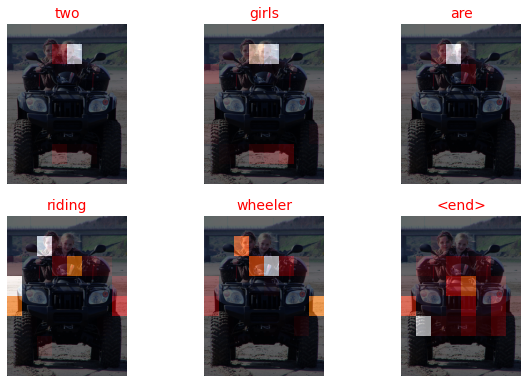

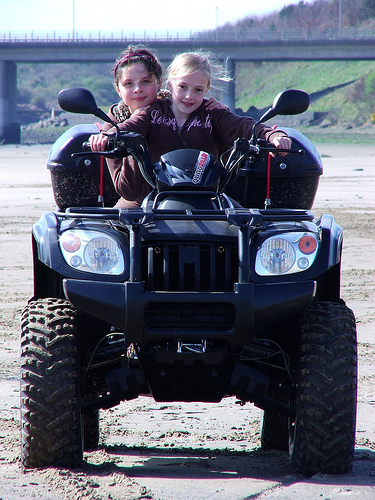

In [105]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.5, 0, 0))
Image.open(test_image)

### Img 7

BLEU score: 100.0
Real Caption: dog is jumping down ramp
Prediction Caption: dog is jumping down ramp


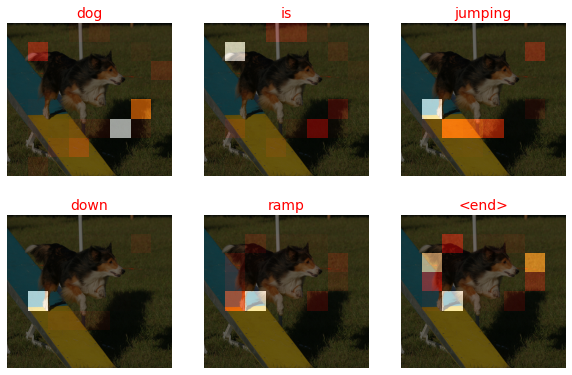

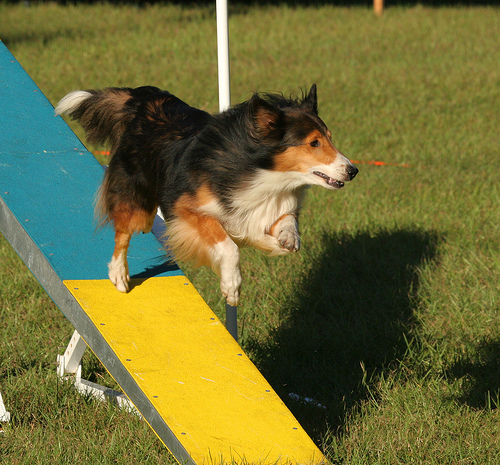

In [110]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.25, 0, 0))
Image.open(test_image)

### Img 8

BLEU score: 100.0
Real Caption: determined girl is hitting volleyball
Prediction Caption: determined girl is hitting volleyball


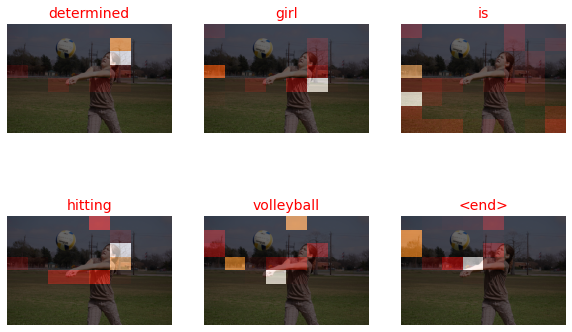

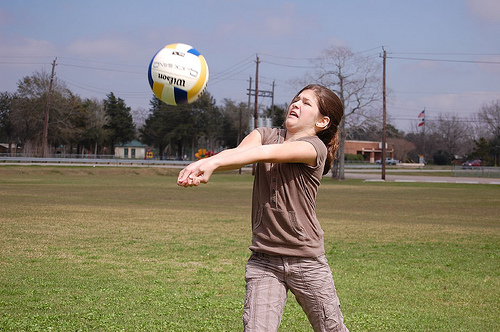

In [117]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.5, 0, 0))
Image.open(test_image)